In [1]:
import pandas as pd

from qiskit import QuantumCircuit, Aer, execute, ClassicalRegister, QuantumRegister
from math import asin, sqrt, ceil
from qiskit.visualization import plot_histogram

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
train = pd.read_csv("./datasets/titanic/train.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# total
cnt_all = len(train)

# list of all survivors
survivors = train[train.Survived.eq(1)]
cnt_survivors = len(survivors)

# calculate the prior probability
prob_survival = len(survivors)/cnt_all

print("The prior probability to survive is: ", round(prob_survival, 2))

The prior probability to survive is:  0.38


In [5]:
def get_modifier_pclass(pclass):
    # number of passengers with the same pclass
    cnt_surv_pclass = len(survivors[survivors.Pclass.eq(pclass)])

    # backward probability
    p_cl_surv = cnt_surv_pclass/cnt_survivors

    # probability of the evidence
    p_cl = len(train[train.Pclass.eq(pclass)])/cnt_all
    return p_cl_surv/p_cl

In [6]:
def get_modifier_sex(sex):
    # number of passengers with the same pclass
    cnt_surv_sex = len(survivors[survivors.Sex.eq(sex)])

    # backward probability
    p_sex_surv = cnt_surv_sex/cnt_survivors

    # probability of the evidence
    p_sex = len(train[train.Sex.eq(sex)])/cnt_all

    return p_sex_surv/p_sex

In [7]:
def pre_process(passenger):
    """
    passenger −− the Pandas dataframe−row of the passenger
    returns a list of modifiers, like this [modifier_a, modifier_b, ...]
    """
    return [
        get_modifier_pclass(passenger["Pclass"]),
        get_modifier_sex(passenger["Sex"]),
    ]

In [8]:
train.iloc[52]

PassengerId                                          53
Survived                                              1
Pclass                                                1
Name           Harper, Mrs. Henry Sleeper (Myna Haxtun)
Sex                                              female
Age                                                  49
SibSp                                                 1
Parch                                                 0
Ticket                                         PC 17572
Fare                                            76.7292
Cabin                                               D33
Embarked                                              C
Name: 52, dtype: object

In [9]:
# a female passenger with 1st class ticket
print (pre_process(train.iloc[52]))

[1.6403508771929822, 1.9332048273550118]


In [10]:
train.iloc[26]

PassengerId                         27
Survived                             0
Pclass                               3
Name           Emir, Mr. Farred Chehab
Sex                               male
Age                                NaN
SibSp                                0
Parch                                0
Ticket                            2631
Fare                             7.225
Cabin                              NaN
Embarked                             C
Name: 26, dtype: object

In [11]:
# a male passenger with 3rd class ticket
print (pre_process(train.iloc[26]))

[0.6314181584306999, 0.49215543190732464]


In [12]:
def prob_to_angle(prob):
    """
    Converts a given P(psi) value into an equivalent theta value.
    """
    return 2*asin(sqrt(prob))

In [13]:
def pqc(backend, prior, modifiers, shots=1, hist=False, measure=False):
    
    # Prepare the circuit with qubits and a classical bit to hold the measurement
    qr = QuantumRegister(7)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

    # the qubit positions
    trunks = 3
    aux = trunks+1
    aux_half = trunks+1
    aux_full = trunks+2
    target = trunks+3

    # Apply prior to qubit to the target qubit
    qc.ry(prob_to_angle(prior), target)

    # Work with the remainder
    qc.x(target)

    # Apply prior to full auxiliary qubit
    qc.cry(prob_to_angle(prior/(1-prior)), target, aux_full)

    # Work with the remainder
    qc.cx(aux_full,target)

    # Apply 0.5*prior to qubit 1
    qc.cry(prob_to_angle(0.5*prior/(1-(2*prior))), target,aux_half)

    # Rearrange states to separated qubits
    qc.x(target)
    qc.cx(aux_full, target)
    
    sorted_modifiers = sorted(modifiers)

    for step in range(0, len(modifiers)):
        
        if sorted_modifiers[step] > 1:
            qc.cry(prob_to_angle(min(1, sorted_modifiers[step]-1)), aux_full, target)

            # separate the aux_full and the target qubit
            qc.ccx(target, aux_full, 0)
            qc.ccx(target, 0, aux_full)
            
            if step == 0:
                # equalize what we transferred to the target (*2) and increase the aux_full to reflect the modifier (*2)
                qc.cry(prob_to_angle(min(1,(sorted_modifiers[step]-1)*2*2)), aux_half, aux_full)

        else: 
            # apply modifier to the target qubit
            qc.cry(prob_to_angle(1-sorted_modifiers[step]), target, step*2)
            qc.cx(step*2,target)

            if step == 0:
                # apply modifier to full auxiliary qubit
                qc.cry(prob_to_angle(1-sorted_modifiers[step]), aux_full, step*2+1)

                # unentangle the full auxiliary from trunk
                qc.cx(step*2+1,aux_full)

    # measure the qubit only if we want the measurement to be included
    if measure:
        qc.measure(qr[target], cr[0])
        
    results = execute(qc,backend, shots=shots).result().get_counts()
    return plot_histogram(results, figsize=(12,4)) if hist else results

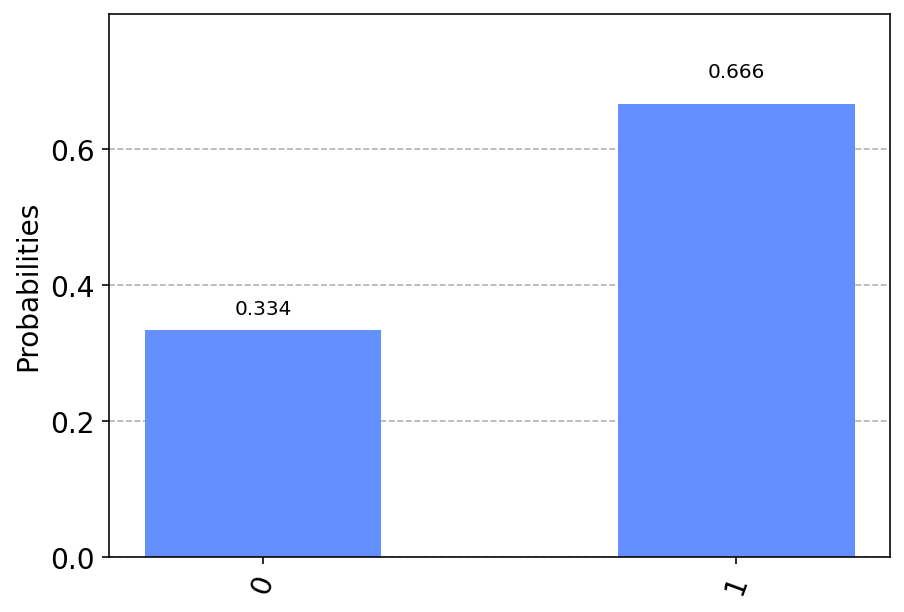

In [14]:
plot_histogram(pqc(Aer.get_backend('qasm_simulator') , 0.38, [1.4, 1.3], shots=1000, hist=False, measure=True))

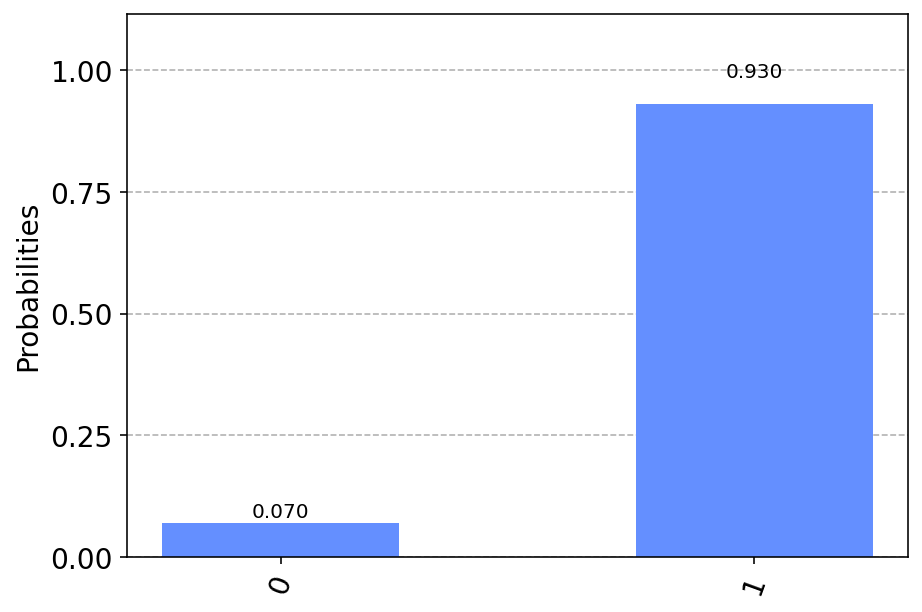

In [15]:
plot_histogram(pqc(Aer.get_backend('qasm_simulator') , 0.38, 
                   [1.6403508771929822, 1.9332048273550118], shots=1000, hist=False, measure=True))

In [16]:
def post_process(counts):
    """
    counts -- the result of the quantum circuit execution
    returns the prediction
    """
    return int(list(map(lambda item: item[0], counts.items()))[0])

In [17]:
def run(f_classify, x):
    return list(map(f_classify, x))

def specificity(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[0][1]) if (matrix[0][0]+matrix[0][1] > 0) else 0

def npv(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[1][0]) if (matrix[0][0]+matrix[1][0] > 0) else 0

def classifier_report(name, run, classify, input, labels):
    
    cr_predictions = run(classify, input)
    cr_cm = confusion_matrix(labels, cr_predictions)

    cr_precision = precision_score(labels, cr_predictions)
    cr_recall = recall_score(labels, cr_predictions)
    cr_specificity = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_level = 0.25*(cr_precision + cr_recall + cr_specificity + cr_npv)

    print('The precision score of the {} classifier is {:.2f}'.format(name, cr_precision))
    print('The recall score of the {} classifier is {:.2f}'.format(name, cr_recall))
    print('The specificity score of the {} classifier is {:.2f}'.format(name, cr_specificity))
    print('The npv score of the {} classifier is {:.2f}'.format(name, cr_npv))
    print('The information level is: {:.2f}'.format(cr_level))

In [18]:
def run(f_classify, data):
    return [f_classify(data.iloc[i]) for i in range(0,len(data))]

# specify a reusable backend
backend = Aer.get_backend('qasm_simulator') 

# evaluate the Quantum Naive Bayes classifier
classifier_report("QuantumNaiveBayes",
    run,
    lambda passenger: post_process(pqc(backend, prob_survival, pre_process(passenger), measure=True, hist=False)),
    train,
    train['Survived'])

The precision score of the QuantumNaiveBayes classifier is 0.61
The recall score of the QuantumNaiveBayes classifier is 0.59
The specificity score of the QuantumNaiveBayes classifier is 0.76
The npv score of the QuantumNaiveBayes classifier is 0.75
The information level is: 0.68
